**Objective**: Given a review, determine whether the review is positive or negative. For a review to be termed positive a rating of 4-5 was considered, whereas for a review to be termed negative a rating of 1-2 was considered.

# Table of Contents
1. [Pre-processing](#pre) <br>
   1.1. [Text pre-processing](#txtpre) <br>
2. [Splitting of data](#split) <br>
3. [Creating data matrix](#feat) <br>
   3.1. [Bag of Words Encoding](#bow) <br>
   3.2. [TFIDF Encoding](#tfidf) <br> 
4. [Applying Multinomial Naive Bayes)](#mulnb) <br>
   4.1. [Set-1 Review text, preprocessed one converted into vectors using (BOW)](#set1) <br>
   4.2. [Set-2 Review text, preprocessed one converted into vectors using (TFIDF)](#set2) <br>
6. [Conclusion using PrettyTable Library](#conc) <br>

In [1]:
#For Warnings
import warnings
warnings.filterwarnings('ignore')

#Usual ML Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#for sqlite database
import sqlite3

In [2]:
#Establishing a connection to read SQlite data.
con = sqlite3.connect('database.sqlite')

# 1. Pre-processing
<a id='pre'></a>

In [3]:
#For filtering we will take only Positive and Negative data.
#That is, we wont consider data where product ratings/score = 3.

filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con)

In [4]:
#Giving scores with >3 a positive rating(0) and scores with <3 a negative rating(1)

def partition(x):
    if x < 3:
        return 0
    return 1

In [5]:
#Loadingt the whole column Score into acutalScore which contains ratings
actualScore = filtered_data['Score']

#Using map() function, we apply the user-defined method partition() on actualScore variable and store in positiveNegative
positiveNegative = actualScore.map(partition) 

#Changing the column to positive and negative
filtered_data['Score'] = positiveNegative

print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
pd.read_sql_query(
    """SELECT * 
    FROM Reviews WHERE Score != 3 and UserId="AR5J8UI46CURR"
    ORDER BY ProductID
    """, con)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


**Analysis:** We can see that the same userid has 5 reviews at exactly the same timestamp for same product. Hence we will need to drop the duplicate values.

In [7]:
#Sorting data according to ProductId in ascending order.

sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False)

In [8]:
#Dropping the duplicates and keeping only the first occurence in the final DataFrame

final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [9]:
#This shows we have only 92.14% of the remianing data.
(final.shape[0]/filtered_data.shape[0])*100

69.25890143662969

In [10]:
#Calculating the total values remaining after dropping the duplicates -> 99.72

#Formula:
#Id of final DataFrame (Containing Dropped values) / filtered_data (Unmodified Values) * 100

(final['Id'].size/filtered_data['Id'].size)*100

69.25890143662969

In [11]:
final['Score'].value_counts()

1    307063
0     57110
Name: Score, dtype: int64

In [12]:
# Removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
print(final.shape)
final[30:50]

(364171, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
138676,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,1,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,1,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
138681,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,1,1065830400,Can't explain why,This book has been a favorite of mine since I ...
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,1,1332547200,The best drink mix,This product by Archer Farms is the best drink...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
284375,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,1,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,1,1229385600,Excellent treats,I have been feeding my greyhounds these treats...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,1,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...


In [13]:
final = final[final['ProductId'] != '2841233731']
final = final[final['ProductId'] != '0006641040']
final.shape

(364136, 10)

## 1.1 Text Pre-processing: Stemming, Stop-words removal, Lemmatization
<a id='txtpre'></a>

In [14]:
import re #Library for regular expressions.

import string

#module for removing stopwords from the documents/reviews.
from nltk.corpus import stopwords 

#module to perform the process of stemming.
#Two kinds of stemming: 1. Porter stemming 2. Snowball stemming
from nltk.stem import PorterStemmer

#module for the process of lemmatization.
from nltk.stem.wordnet import WordNetLemmatizer

In [15]:
#Printing the 1st review
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

#Printing the 1000th review
sent_1000 = final['Text'].values[10000]
print(sent_1000)
print("="*50)

#Printing the 1500th review
sent_1500 = final['Text'].values[15000]
print(sent_1500)
print("="*50)

#Printing the 4900th review
sent_4900 = final['Text'].values[45000]
print(sent_4900)
print("="*50)

This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!
Absolutely delicious on a simple grilled sausage; critical in certain recipes.  This product bears no resemblance to the overprocessed, over-colored, over-sugared GLOP that passes for mustard in this country; the mustard seeds are whole and fill your mouth with flavor. Subtly different from Dijon mustard, which is made with white wine, Moutarde Meaux is made with vinegar and the added tang is just sublime...  No pantry should be without it, and you will never, ever go back to the yellow stuff.
I do not know any European ladies that do no use it. I buy it from European stores for less than here on Amazon. Vegeta wi

**As you can see, we have html tags in the review. There are some URLs also.**

In [16]:
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


In [17]:
#Using beautifulsoup for removing HTML tags

from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!
Absolutely delicious on a simple grilled sausage; critical in certain recipes.  This product bears no resemblance to the overprocessed, over-colored, over-sugared GLOP that passes for mustard in this country; the mustard seeds are whole and fill your mouth with flavor. Subtly different from Dijon mustard, which is made with white wine, Moutarde Meaux is made with vinegar and the added tang is just sublime...  No pantry should be without it, and you will never, ever go back to the yellow stuff.
I do not know any European ladies that do no use it. I buy it from European stores for less than here on Amazon. Vegeta wi

In [18]:
#Expanding english language contraction in NLP:
#you've -> you have, 're -> are etc.

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)

I do not know any European ladies that do no use it. I buy it from European stores for less than here on Amazon. Vegeta without MSG is available as well, but I do not find it so flavorful. Remember that it contains salt, and adding additional salt to your cooking might not be necessary. I add Vegeta to taste 1st, and then any other spices and herbs I might feel like.<br />Try it on your grilling food of choice, too, by itself or with other spices/herbs.(Do not add more salt, though.)


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your  oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains  calories per packet. Thank you Archer Farms!


In [21]:
#remove special character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I do not know any European ladies that do no use it I buy it from European stores for less than here on Amazon Vegeta without MSG is available as well but I do not find it so flavorful Remember that it contains salt and adding additional salt to your cooking might not be necessary I add Vegeta to taste 1st and then any other spices and herbs I might feel like br Try it on your grilling food of choice too by itself or with other spices herbs Do not add more salt though 


In [22]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []

# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364136/364136 [08:14<00:00, 735.72it/s] 


In [24]:
final['Text'] = preprocessed_reviews

In [25]:
#Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last').reset_index(drop=True)
X = time_sorted_data['Text']
y = time_sorted_data['Score']

# 2. Splitting the Data

<a id='split'></a>

In [26]:
# train test split before vectorizing or performing any feature engineering techniques
#as doing it before will lead to data leakage.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=False)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33,  random_state=0, shuffle=False)

# 3. Creating data matrix

<a id='feat'></a>

## 3.1. Bag of Words Encoding
<a id='bow'></a>

In [27]:
#BoW for preprocessed review.
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_review_bow = vectorizer.transform(X_train)
X_cv_review_bow = vectorizer.transform(X_cv)
X_test_review_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_review_bow.shape, y_train.shape)
print(X_cv_review_bow.shape, y_cv.shape)
print(X_test_review_bow.shape, y_test.shape)

(163460,) (163460,)
(80511,) (80511,)
(120165,) (120165,)
After vectorizations
(163460, 15790) (163460,)
(80511, 15790) (80511,)
(120165, 15790) (120165,)


## 3.2. TFIDF Encoding
<a id='tfidf'></a>

In [28]:
#TF-IDF Encoding of reviews
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_review_tfidf = TfidfVectorizer(min_df=10)
vectorizer_review_tfidf.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_review_tfidf = vectorizer_review_tfidf.transform(X_train)
X_cv_review_tfidf = vectorizer_review_tfidf.transform(X_cv)
X_test_review_tfidf = vectorizer_review_tfidf.transform(X_test)

print("After vectorizations")
print(X_train_review_tfidf.shape, y_train.shape)
print(X_cv_review_tfidf.shape, y_cv.shape)
print(X_test_review_tfidf.shape, y_test.shape)

After vectorizations
(163460, 15790) (163460,)
(80511, 15790) (80511,)
(120165, 15790) (120165,)


# 4. Applying Multinomial Naive Bayes

<a id='mulnb'></a>

## Set 1: Review text, preprocessed one converted into vectors using (BOW)
<a id='set1'></a>

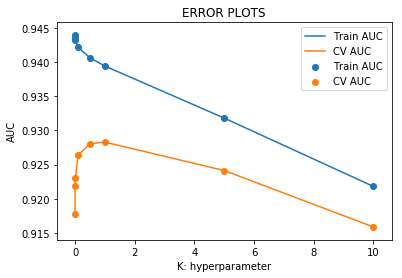

In [40]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

train_auc = []
cv_auc = []
alpha = [0.0005, 0.005, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
for i in alpha:
    model = MultinomialNB(alpha=i, fit_prior=False)
    model.fit(X_train_review_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_review_bow)[:,1]
    y_cv_pred =  model.predict_proba(X_cv_review_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(alpha, train_auc, label='Train AUC')
plt.scatter(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

AUC of Train Data: 0.94
AUC of Test Data: 0.92


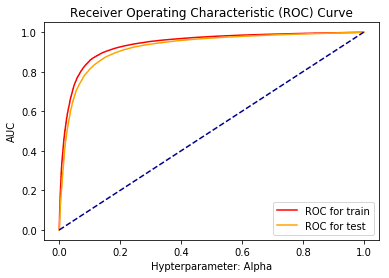

In [41]:
#Citation: plot roc auc curve
#url: https://stackabuse.com/understanding-roc-curves-with-python/

best_alpha = 1

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

model = MultinomialNB(alpha=best_alpha)
model.fit(X_train_review_bow, y_train)

def plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr):  
    plt.plot(train_fpr, train_tpr, color='red', label='ROC for train')
    plt.plot(test_fpr, test_tpr, color='orange', label='ROC for test')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Hypterparameter: Alpha')
    plt.ylabel('AUC')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
y_test_pred = model.predict_proba(X_test_review_bow)  
y_test_pred = y_test_pred[:, 1]

y_train_pred = model.predict_proba(X_train_review_bow)  
y_train_pred = y_train_pred[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred)  
print('AUC of Train Data: %.2f' % auc_train)  

auc_test = roc_auc_score(y_test, y_test_pred)  
print('AUC of Test Data: %.2f' % auc_test)  

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)  

plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr)

In [42]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.028


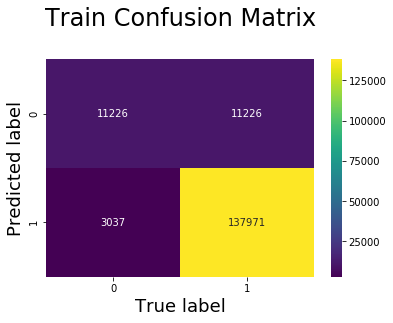

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999994343463 for threshold 0.029


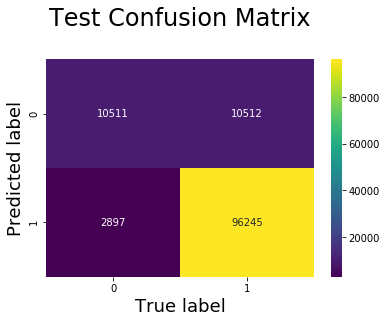

In [43]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict(y_train_pred, train_thresholds, train_fpr, train_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_train, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Train Confusion Matrix\n",size=24)
plt.show()

print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_test, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Test Confusion Matrix\n",size=24)
plt.show()

## Top 20 features of positive and negative class for set 1

In [33]:
# Now we can find log probabilities of different features for both the classes
class_features = model.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = vectorizer.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 20 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))

Top 20 Important Features and their log probabilities For Negative Class :


not	 -->	-3.278578  
like	 -->	-4.402319  
would	 -->	-4.667962  
product	 -->	-4.669552  
taste	 -->	-4.675483  
one	 -->	-4.841872  
good	 -->	-5.068839  
flavor	 -->	-5.133615  
no	 -->	-5.134882  
coffee	 -->	-5.171585  
tea	 -->	-5.354545  
get	 -->	-5.414987  
even	 -->	-5.419550  
amazon	 -->	-5.428497  
buy	 -->	-5.482133  
much	 -->	-5.487272  
food	 -->	-5.496068  
really	 -->	-5.569377  
could	 -->	-5.679222  
tried	 -->	-5.694000  


Top 20 Important Features and their log probabilities For Positive Class :


not	 -->	-3.722389  
like	 -->	-4.561082  
good	 -->	-4.666585  
great	 -->	-4.718742  
one	 -->	-4.881752  
tea	 -->	-4.889972  
taste	 -->	-4.942957  
flavor	 -->	-5.064019  
product	 -->	-5.088867  
love	 -->	-5.089735  
coffee	 -->	-5.101401  
would	 -->	-5.149081  
get	 -->	-5.358230  
no	 -->	-5.372776  
amazon	 -->	-5.406597  
best	 -->	-5.422517  
really	 -->	-5.437070  
use	 -->	-5.46

## Set 2: Review text, preprocessed one converted into vectors using (TFIDF)
<a id='set2'></a>

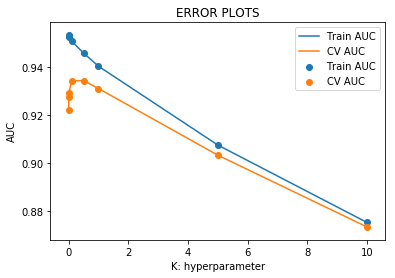

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

train_auc = []
cv_auc = []
alpha = [0.0005, 0.005, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
for i in alpha:
    model2 = MultinomialNB(alpha=i, fit_prior=False)
    model2.fit(X_train_review_tfidf, y_train)
    
    y_train_pred =  model2.predict_proba(X_train_review_tfidf)[:,1]
    y_cv_pred =  model2.predict_proba(X_cv_review_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(alpha, train_auc, label='Train AUC')
plt.scatter(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

AUC of Train Data: 0.94
AUC of Test Data: 0.93


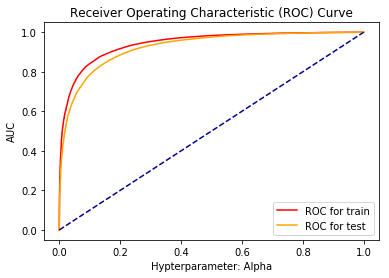

In [45]:
#Citation: plot roc auc curve
#url: https://stackabuse.com/understanding-roc-curves-with-python/

best_alpha = 1.0

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

model2 = MultinomialNB(alpha=best_alpha)
model2.fit(X_train_review_tfidf, y_train)

def plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr):  
    plt.plot(train_fpr, train_tpr, color='red', label='ROC for train')
    plt.plot(test_fpr, test_tpr, color='orange', label='ROC for test')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Hypterparameter: Alpha')
    plt.ylabel('AUC')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
y_test_pred = model.predict_proba(X_test_review_tfidf)  
y_test_pred = y_test_pred[:, 1]

y_train_pred = model.predict_proba(X_train_review_tfidf)  
y_train_pred = y_train_pred[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred)  
print('AUC of Train Data: %.2f' % auc_train)  

auc_test = roc_auc_score(y_test, y_test_pred)  
print('AUC of Test Data: %.2f' % auc_test)  

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)  

plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr)

In [46]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.668


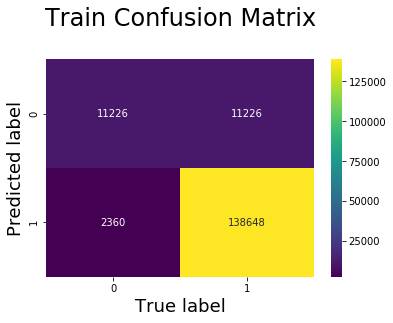

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999943434634 for threshold 0.683


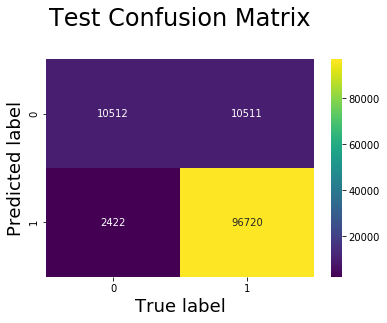

In [47]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict(y_train_pred, train_thresholds, train_fpr, train_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_train, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Train Confusion Matrix\n",size=24)
plt.show()

print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_test, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Test Confusion Matrix\n",size=24)
plt.show()

## Top 20 features of positive and negative class for set 2

In [39]:
# Now we can find log probabilities of different features for both the classes
class_features = model2.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = vectorizer_review_tfidf.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 20 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))

Top 20 Important Features and their log probabilities For Negative Class :


not	 -->	-4.406294  
like	 -->	-5.208417  
taste	 -->	-5.314473  
product	 -->	-5.317737  
would	 -->	-5.342039  
coffee	 -->	-5.599196  
one	 -->	-5.610665  
flavor	 -->	-5.741324  
no	 -->	-5.764979  
good	 -->	-5.820462  
tea	 -->	-5.851165  
buy	 -->	-5.853645  
even	 -->	-5.960530  
get	 -->	-6.017157  
amazon	 -->	-6.023632  
much	 -->	-6.027646  
bad	 -->	-6.031024  
box	 -->	-6.035116  
bought	 -->	-6.059898  
really	 -->	-6.114200  


Top 20 Important Features and their log probabilities For Positive Class :


not	 -->	-4.837558  
great	 -->	-5.148734  
good	 -->	-5.230830  
tea	 -->	-5.270419  
like	 -->	-5.316634  
coffee	 -->	-5.397483  
love	 -->	-5.411582  
product	 -->	-5.506781  
taste	 -->	-5.523952  
one	 -->	-5.556670  
flavor	 -->	-5.573111  
best	 -->	-5.684900  
amazon	 -->	-5.782825  
would	 -->	-5.790261  
find	 -->	-5.819809  
price	 -->	-5.836763  
really	 -->	-5.837375  
get	 -->	-5.

# 6. Conclusion
<a id='conc'> </a>

In [62]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Set", "Vectorizer", "Model", "Best Hyper-parameter (Alpha)" , "AUC of Test Data"]

x.add_row(["Set 1", "Bag Of Words", "Multinomial Naive Bayes", 1.0, 0.92])
x.add_row(["Set 2", "TF-IDF", "Multinomial Naive Bayes", 1.0, 0.93])

print(x)

+-------+--------------+-------------------------+------------------------------+------------------+
|  Set  |  Vectorizer  |          Model          | Best Hyper-parameter (Alpha) | AUC of Test Data |
+-------+--------------+-------------------------+------------------------------+------------------+
| Set 1 | Bag Of Words | Multinomial Naive Bayes |             1.0              |       0.92       |
| Set 2 |    TF-IDF    | Multinomial Naive Bayes |             1.0              |       0.93       |
+-------+--------------+-------------------------+------------------------------+------------------+
